In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/Ocean180/src

Mounted at /content/drive
/content/drive/MyDrive/Ocean180/src


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
from tqdm import tqdm
import gc
import pickle
import random
from pathlib import Path

import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

In [4]:
class CFG:
    VER = 1
    AUTHOR = 'endo'
    METHOD = 'lightgbm'
    COMPETITION = 'ocean180'
    DATA_PATH = Path('../data') # データへのpathを設定
    SAVE_FOLDER = Path('save_folder1')
    MODEL_PATH = SAVE_FOLDER / 'models'
    FEATURE_PATH = SAVE_FOLDER / 'features'
    OTHER_PATH = SAVE_FOLDER / 'others'

    target_col = 'cover'
    seed = 42
    num_fold = 3
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': 'gbdt',
        'seed': seed,
    }

## Preprocessing

In [5]:
def preprocessing(input_df: pd.DataFrame)->pd.DataFrame:
    output_df = input_df.copy()
    # 特徴量を追加していく
    return output_df

def get_train_data()->pd.DataFrame:
    # id, ymd>>書式が多すぎて統一できない, Landsat_StartTime, PRODUCT_ID
    df = pd.read_csv(CFG.DATA_PATH / 'train_data.csv')# .drop(['Unnamed: 0', 'YMD', 'Landsat_StartTime', 'PRODUCT_ID'], axis=1)
    return preprocessing(df)

def get_test_data():
    df = pd.read_csv(CFG.DATA_PATH / 'test_data.csv')# .drop(['Unnamed: 0', 'YMD', 'Landsat_StartTime', 'PRODUCT_ID'], axis=1)
    return preprocessing(df)

## Learning

In [6]:
def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def lgb_training(train, features):
    CFG.folds = get_groupkfold(train, CFG.target_col, 'mesh20', CFG.num_fold)
    CFG.folds.to_csv(CFG.OTHER_PATH/'folds.csv', index=False)
    oof_pred = np.zeros(len(train), dtype=np.float64)
    df_importance = pd.DataFrame({'feature': features})
    df_importance['importance'] = 0
    for fold in range(CFG.num_fold):
        idx_train = CFG.folds!=fold
        idx_valid = CFG.folds==fold
        x_train = train[idx_train][features]
        y_train = train[idx_train][CFG.target_col]
        x_valid = train[idx_valid][features]
        y_valid = train[idx_valid][CFG.target_col]
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)
        model = lgb.train(
            params = CFG.lgb_params,
            train_set = lgb_train,
            num_boost_round = 1000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 50,
        )
        model_path = f'{CFG.METHOD}_fold{fold}_seed{CFG.seed}_ver{CFG.VER}.pkl'
        pickle.dump(model, open(CFG.MODEL_PATH/model_path, 'wb'))
        oof_pred[idx_valid] = model.predict(x_valid)

        f_importance = np.array(model.feature_importance())
        temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
        df_importance['importance'] += temp_importance['importance']
    
    df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
    df_importance = df_importance.sort_values('importance', ascending=False)
    df_importance.to_csv(CFG.OTHER_PATH / f'{CFG.METHOD}_feature_importance_seed{CFG.seed}_ver{CFG.VER}.csv', header=True, index=False)
    display(df_importance.head(50))
    score = np.sqrt(mean_squared_error(train[CFG.target_col], oof_pred))
    np.save(CFG.OTHER_PATH / f'oof_pred_{CFG.METHOD}_seed{CFG.seed}_ver{CFG.VER}', oof_pred)
    print(f'CV Score: {score}')

## Prediction

In [7]:
def lgb_Predicting(test, features):
    test_preds = np.zeros((len(test), CFG.num_fold))
    x_test = test[features]
    for fold in range(CFG.num_fold):
        model_path = f'{CFG.METHOD}_fold{fold}_seed{CFG.seed}_ver{CFG.VER}.pkl'
        model = pickle.load(open(CFG.MODEL_PATH / model_path, 'rb'))
        test_preds[:, fold] = model.predict(x_test)
    np.save( CFG.OTHER_PATH / f'oof_pred_{CFG.METHOD}_seed{CFG.seed}_ver{CFG.VER}', test_preds)
    pd.DataFrame(np.mean(test_preds, axis=1)).to_csv(CFG.SAVE_FOLDER / f'submit_{CFG.METHOD}_seed{CFG.seed}_ver{CFG.VER}.csv', header=False)

## EDA

In [8]:
train = get_train_data()
test = get_test_data()
all_df = pd.concat([train, test])
train.shape, test.shape, all_df.shape

((14140, 3465), (4039, 3464), (18179, 3465))

In [9]:
all_df['grid_20m'] = ((all_df['lon']-122)/(1/4550)*100000 + (all_df['lat']-24)/(1/4500)).astype(int)

In [10]:
null_cols = all_df.isna().any()
null_cols_names = null_cols[null_cols == True].index.tolist()
null_cols_names

['area',
 'YMD',
 'cover',
 'depth_original',
 'cliff_length',
 'aicial_length',
 'beach_length',
 'coast_length',
 'coastal_dist',
 'cold_sst',
 'depth',
 'fetch',
 'hist_cold_sst',
 'hist_warm_sst',
 'river_area',
 'river_dist',
 'Salinity_annual',
 'warm_sst',
 'sst_ymd',
 'sst_diff',
 'Blue',
 'Green',
 'Red',
 'NIR',
 'SWIR1',
 'TIRS1',
 'TIRS2',
 'SWIR2',
 'MSAVI',
 'EVI',
 'NBR',
 'NBR2',
 'NDMI',
 'NDVI',
 'NDWI',
 'SAVI',
 'TSAVI',
 'Alteration',
 'AVI',
 'BWDRVI',
 'Chlgreen',
 'Cigreen',
 'Cirededge',
 'Chlred_edge',
 'CVI',
 'CI',
 'CTVI',
 'CRI550',
 'D678_500',
 'DVIMSS',
 'DSWI',
 'DSWI_5',
 'Fe3',
 'Ferric_Oxides',
 'Ferrous_Silicates',
 'GEMI',
 'GVMI',
 'Gossan',
 'GARI',
 'GLI',
 'H',
 'IR550',
 'mCRIG',
 'mCRIRE',
 'MVI',
 'MCARI1',
 'MCARI2',
 'NLI',
 'NormG',
 'NormR',
 'PPR',
 'PSNDc2',
 'RDVI',
 'IF',
 'SLAVI',
 'SIPI2',
 'VARIgreen',
 'sunAzimuth',
 'sunElevation',
 'Date_Acquired',
 'Landsat_StartTime',
 'PRODUCT_ID',
 'Landsat_num',
 'MAX_AFRI1600',
 'MAX_AOT

In [11]:
all_df.head(5)

Unnamed: 0        lat         lon  area                  YMD    year  \
0           0  24.989139  125.243167  20.0             20110926  2011.0   
1           1  26.996172  127.912024  40.0   2009.7.6-2009.7.28  2009.0   
2           2  26.363556  127.735139  20.0             20091014  2009.0   
3           3  26.991255  127.912302  40.0  2009.1.13-2009.2.19  2009.0   
4           4  26.988254  127.917254  40.0  2009.1.13-2009.2.19  2009.0   

   month  cover  depth_original  cliff_length  aicial_length  beach_length  \
0    9.0  0.050             NaN           0.0       0.000000      0.000000   
1    7.0  0.725             NaN           0.0       0.478772    949.173828   
2   10.0  0.025             NaN           0.0     180.985031    521.317383   
3    1.0  0.575             NaN           0.0       0.361444    799.384399   
4    1.0  0.225             NaN           0.0       6.062498    954.537293   

   coast_length  coastal_dist   cold_sst      depth        fetch  \
0      0.000000        5590.0  22.672894  23.664240  2590.515869   
1    949.652588          50.0  20.892162   0.000000  1534.726807   
2    702.302429         205.0  21.143721   0.191638   766.555908   
3    799.745850         150.0  20.891870   2.553752  1542.904297   
4    960.599793         210.0  20.883181   9.874817  1354.861572   

   hist_cold_sst  hist_warm_sst  river_area  river_dist  Salinity_annual  \
0      20.798887      31.061762      2986.0  126.328598        34.560532   
1      18.412085      30.809059      1920.0   36.931263        34.657925   
2      19.327492      31.236162      3694.0    1.586363        34.709606   
3      18.409414      30.816591      1920.0   36.497868        34.658588   
4      18.379198      30.824339      1920.0   35.928719        34.658199   

    warm_sst  sst_annual    sst_ymd  sst_diff       Blue      Green  \
0  29.149746   25.886436  28.750600 -2.864164  44.513775  24.466267   
1  28.947212   24.752906  27.285750 -2.532844  76.809082  72.848259   
2  29.123978   24.983584  26.944032 -1.960448  51.095936  34.678707   
3  28.945391   24.756948  21.462371  3.294577        NaN        NaN   
4  28.924425   24.729167  21.429968  3.299199  58.162979  30.404083   

         Red        NIR     SWIR1     TIRS1     TIRS2     SWIR2     MSAVI  \
0  12.291277   4.496400  0.274631  8.243456  8.218559  0.126413 -1.371784   
1  50.989620  70.342323  6.375916  8.649507  8.658948  1.017969  0.273709   
2  18.480610   7.821566  0.640860  8.279950  8.255633  0.114172 -1.195080   
3        NaN        NaN       NaN       NaN       NaN       NaN       NaN   
4   9.919600   4.474403  0.213160  8.385872  8.375682  0.036060 -0.995109   

        EVI       NBR      NBR2      NDMI      NDVI      NDWI      SAVI  \
0  0.076538  0.945309  0.369581  0.884876 -0.464321  0.689504 -0.676338   
1 -0.243384  0.971470  0.724646  0.833784  0.159502  0.017501  0.238271   
2  0.101124  0.971226  0.697570  0.848540 -0.405253  0.631929 -0.596540   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4  0.036670  0.984011  0.710619  0.909053 -0.378296  0.743429 -0.548395   

      TSAVI  Alteration        AVI    BWDRVI  Chlgreen   Cigreen  Cirededge  \
0 -0.716042    2.172491 -15.589754 -0.980000  5.441301 -0.816220  -0.634180   
1  0.072192    6.263373  38.705406 -0.832205  1.035625 -0.034399   0.379542   
2 -0.638658    5.613106 -21.318088 -0.969846  4.433729 -0.774456  -0.576769   
3       NaN         NaN        NaN       NaN       NaN       NaN        NaN   
4 -0.601136    5.911293 -10.890392 -0.984732  6.795114 -0.852835  -0.548933   

   Chlred_edge       CVI        CI      CTVI    CRI550   D678_500      DVIMSS  \
0     2.733582  0.092327 -2.621574  0.410823 -0.018408 -32.222498   -1.499917   
1     0.724878  0.675865 -0.506367  0.568762 -0.000708 -25.819462  117.831956   
2     2.362776  0.120194 -1.764840  0.441918 -0.009265 -32.615326    0.291149   
3          NaN       NaN       NaN       NaN       NaN        NaN         NaN

In [12]:
all_df.shape

(18179, 3466)

In [13]:
all_df["grid_20m"].nunique()

16671

In [14]:
all_df[~all_df['cover'].isnull()].shape

(14140, 3466)

In [15]:
all_df[~all_df['cover'].isnull()]['grid_20m'].nunique()

12795

In [16]:
all_df[all_df['cover'].isnull()]['grid_20m'].nunique()

3876

In [17]:
12795+3876

16671

In [18]:
# trainとtestはgrid_20m上では完全に独立らしい but 同じデータ内では一緒のものもある

In [19]:
all_df["mesh20"].nunique()

56

In [20]:
all_df[~all_df['cover'].isnull()]['mesh20'].nunique()

51

In [21]:
all_df[all_df['cover'].isnull()]['mesh20'].nunique()

17

In [22]:
# 可視化
import folium
from folium import Map, Marker
from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster()
map = Map(location=[25.5, 127], zoom_start=10)

for i, r in train[['lat', 'lon']].iterrows():
    Marker(location=[r['lat'], r['lon']], icon=folium.Icon(color='red')).add_to(marker_cluster)

for i, r in test[['lat', 'lon']].iterrows():
    Marker(location=[r['lat'], r['lon']], icon=folium.Icon(color='blue')).add_to(marker_cluster)

marker_cluster.add_to(map)
map.save("map_ocean.html")

In [23]:
all_df['lon'].max() - all_df['lon'].min()

8.401722000000007

In [24]:
all_df['lat'].max() - all_df['lat'].min()

3.0513329999999996

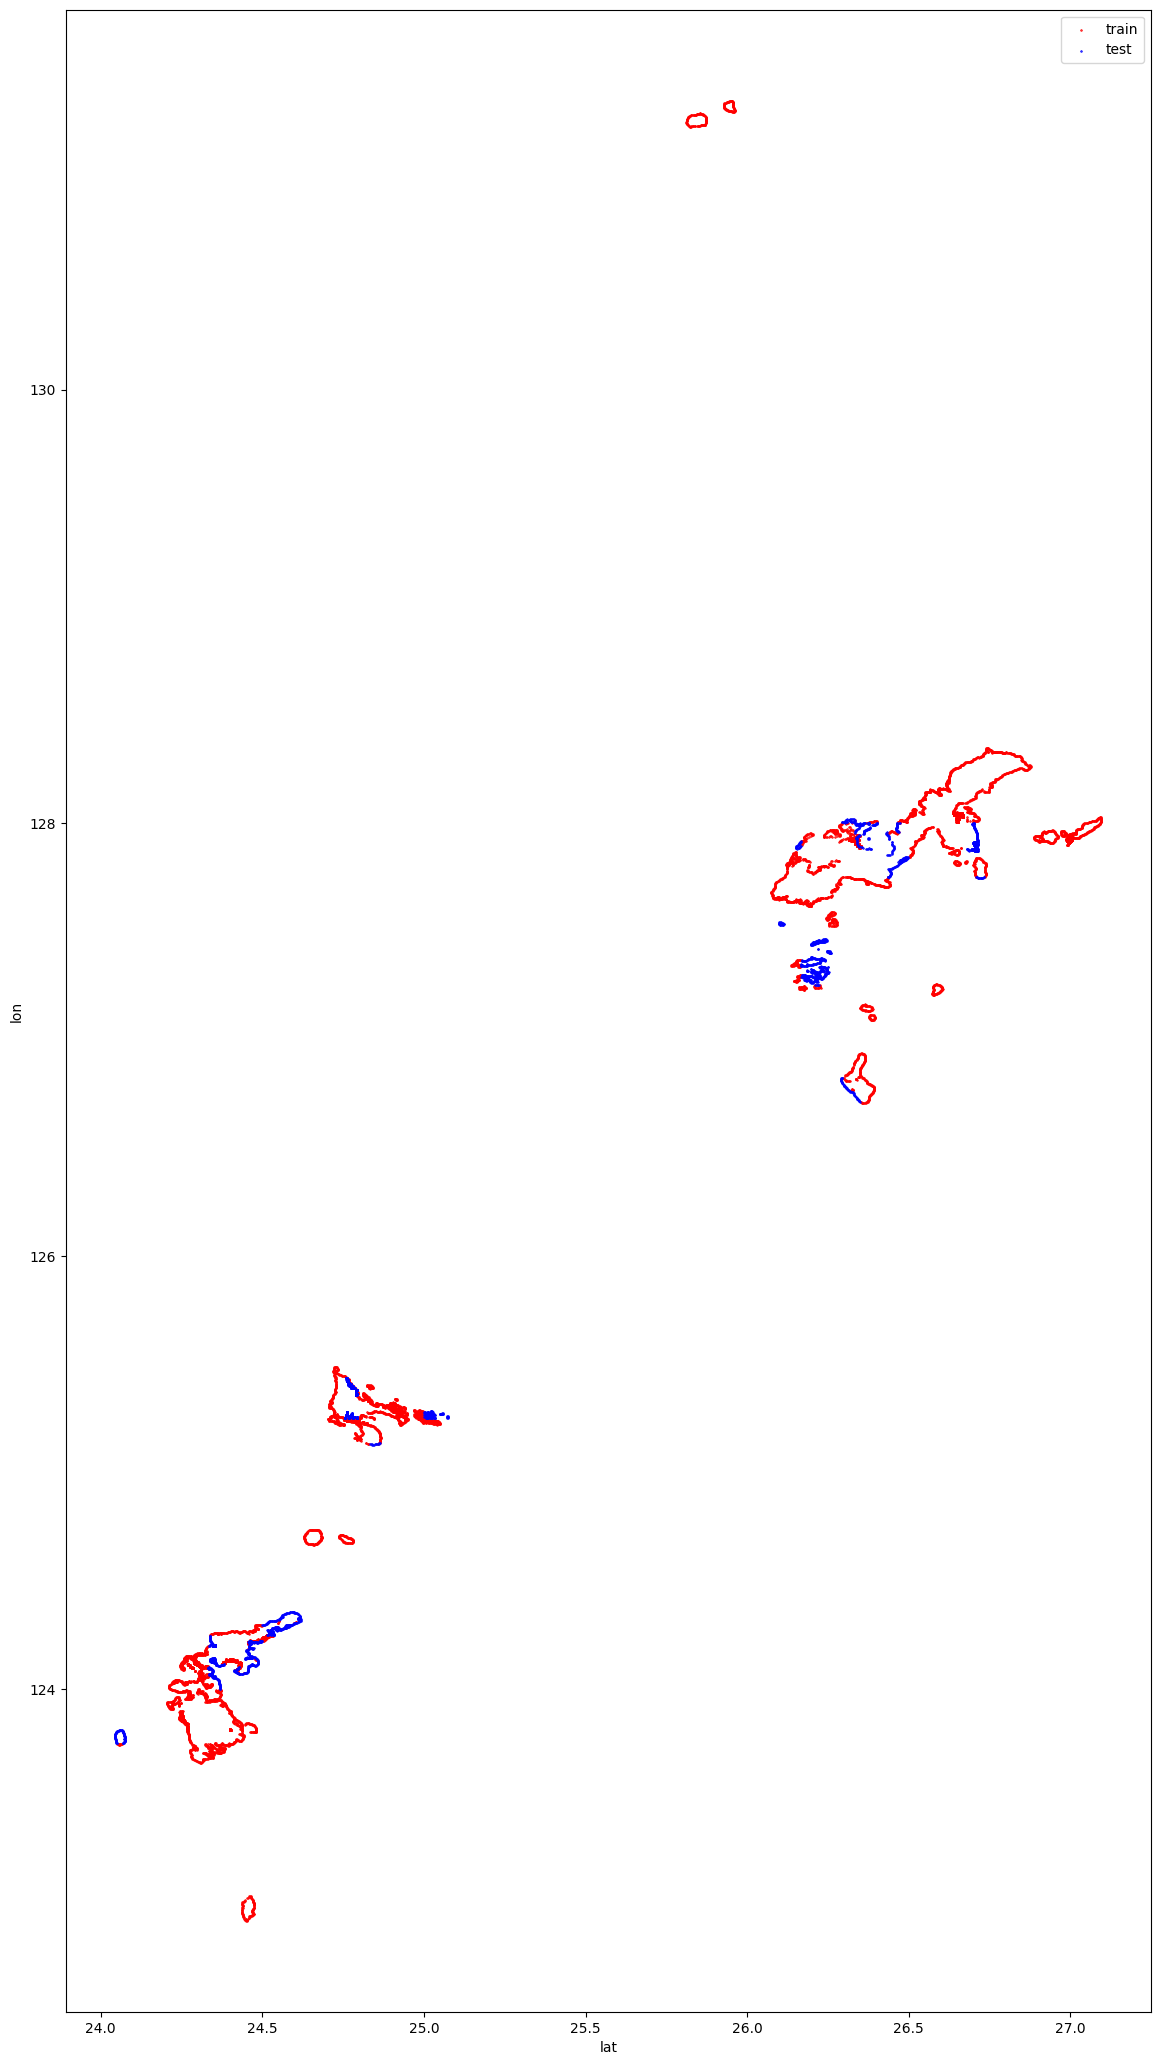

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,26))

plt.scatter(train['lat'], train['lon'], color='red', label='train', s=1, alpha=0.7, marker='*')
plt.scatter(test['lat'], test['lon'], color='blue', label='test', s=1, alpha=0.7, marker='*')

# 軸ラベルを設定
plt.xlabel('lat')
plt.ylabel('lon')

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

In [26]:
# 特徴量作成について
# 年を軸にしたデータに変換 >> 1y_before, 1y_next

# CVについて
# train dataとtest dataで独立しているのは mesh20 ではなく grid_20m (座標)

# temp

In [27]:
all_df['year'] = all_df['year'].astype(int)

In [28]:
import re
year_columns_patterns = [col.replace(re.findall("2010", col)[0], "") for col in all_df.columns if re.findall("2010", col)]
year_columns = [col for col in all_df.columns if re.findall("20\d{2}", col)]

In [29]:
all_df.shape

(18179, 3466)

In [30]:
year_lag_dict = {}
for i in range(22):# 0>20
    year = 1999 + i
    year_lag_dict[year] = {}

    for j in range(7):
        lag = j-3
        lagged_year = year + lag
        if (2000<=lagged_year) and (lagged_year<=2020):
            for c in year_columns_patterns:
                key = f'{c}{lagged_year}'
                year_lag_dict[year][key] = f'{c}{lag}'

In [31]:
len(list(year_lag_dict[2020].values())), len(list(year_lag_dict[2020].keys()))

(600, 600)

In [32]:
def extract_rename(row):
    year = row['year']
    return row[list(year_lag_dict[year].keys())].rename(year_lag_dict[year])

temp_df = all_df.apply(extract_rename, axis=1)
temp_df.shape

(18179, 1050)

In [33]:
all_df.shape

(18179, 3466)

In [34]:
main_df = all_df.drop(year_columns, axis=1)
all_df = pd.concat([main_df, temp_df], axis=1)
all_df.shape

(18179, 1366)

In [35]:
all_df[main_df.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18179 entries, 0 to 4038
Columns: 316 entries, Unnamed: 0 to grid_20m
dtypes: float64(309), int64(3), object(4)
memory usage: 44.0+ MB


In [36]:
127, 127.5

(127, 127.5)

In [37]:
train["mesh20"].nunique()

51

In [38]:
test["mesh20"].nunique()

17

In [39]:
all_df["mesh20"].nunique()

56

In [40]:
temp_df = all_df[127<=all_df['lon']]
temp_df = temp_df[temp_df['lon']<=127.5]
temp_df[['mesh20', 'cover']]

,mesh20,cover
9,3927_01,0.05
15,3927_01,0.05
28,3927_20,0.05
95,3927_30,0.05
179,3927_20,0.05
214,3927_01,0.05
215,3927_20,0.05
228,3927_20,0.05
243,3927_20,0.05
270,3927_01,0.05
